In [2]:
# GAN 모델 구현 : CIFAR10 dataset - color image
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

In [12]:
# generator
generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)  # UpSampling2D와 유사한 기능
# 생성자에서 픽셀공간을 균일하게 다루지 못해 가끔 체스판 모양이 나타나는데 이를 방지하는 효과
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
print(generator.summary())

# discriminator
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
print(discriminator.summary())


discriminator.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005, clipvalue=1.0), loss='binary_crossentropy')
# clipvalue = 기울기 값 자르기, 기울기 폭주 방지(임계값을 넘지 못하도록 함)용
# decay =  학습 진행 시 점차 학습률을 줄임, 학습이 안정적으로 진행

# GAN 모델(적대적 네트워크) 구성
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0003, clipvalue=1.0), loss='binary_crossentropy')

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_16 (Dense)            (None, 32768)             1081344   
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 32768)             0         
                                                                 
 reshape_9 (Reshape)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_25 (Conv2  (None, 32, 32, 256)       104

[[[0.23137255 0.24313726 0.24705882]
  [0.16862746 0.18039216 0.1764706 ]
  [0.19607843 0.1882353  0.16862746]
  ...
  [0.61960787 0.5176471  0.42352942]
  [0.59607846 0.49019608 0.4       ]
  [0.5803922  0.4862745  0.40392157]]

 [[0.0627451  0.07843138 0.07843138]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509805 0.21568628]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117648 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215687 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941177 0.19607843]
  [0.47058824 0.32941177 0.19607843]
  [0.42745098 0.28627452 0.16470589]]

 ...

 [[0.8156863  0.6666667  0.3764706 ]
  [0.7882353  0.6        0.13333334]
  [0.7764706  0.6313726  0.10196079]
  ...
  [0.627451   0.52156866 0.27450982]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333334 0.07843138]]

 [[0.7058824  0.54509807 0.3764706 ]
  [0.6784314  0.48235294 0.16470589]


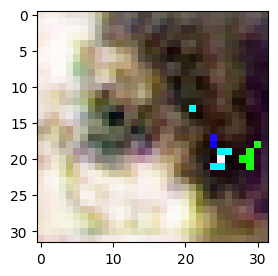

In [18]:
# train
import os
if not os.path.exists("./gan_images"):
  os.mkdir("./gan_images")

from keras.preprocessing import image
from keras.datasets import cifar10
(x_train, y_train), (_, _) = cifar10.load_data()

x_train = x_train[y_train.flatten() == 6] # 6번째 클래스(개구리 이미지)
# print(x_train[0], y_train[0])

x_train = x_train.reshape((x_train.shape[0], ) + (height, width, channels)).astype('float32') / 255
print(x_train[0], y_train[0])

iterations = 1000
batch_size = 20

start = 0
for step in range(1, iterations):
  random_latent_vec = np.random.normal(size=(batch_size, latent_dim)) # 무자위 샘플링
  generated_images = generator.predict(random_latent_vec) # 가짜 이미지 디코딩

  stop = start + batch_size
  real_images = x_train[start:stop]
  # 진짜 이미지와 연결
  combine_images = np.concatenate([generated_images, real_images])

  # 진짜, 가짜 이미지를 구분해 레이블 합치기
  labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

  labels += np.random.random(labels.shape) * 0.05 # 레이블에 랜덤 노이즈를 추가

  d_loss = discriminator.train_on_batch(combine_images, labels)

  random_latent_vector = np.random.normal(size=(batch_size, latent_dim))

  misleading_target = np.zeros((batch_size, 1)) # 모두 가짜이미지라고 레이블을 만듦
  g_loss = gan.train_on_batch(random_latent_vec, misleading_target)

  start += batch_size
  if start > len(x_train) - batch_size:
    start = 0

  if step % 100 == 0:
    gan.save_weights('tf54gan.h5') # 모델 가중치 저장
    print('step %s에서 판별자 손실 : %s'%(step, d_loss))
    print('step %s에서 적대적 손실 : %s'%(step, g_loss))

    # 생성 이미지 저장
    img = image.array_to_img(generated_images[0] * 255., scale = False)
    img.save("./gan_images/frog" + str(step) + '.png')

    # 비교를 위해 진짜 이미지 하나를 저장
    img = image.array_to_img(real_images[0] * 255., scale = False)
    img.save("./gan_images/real_frog" + str(step) + '.png')

import matplotlib.pyplot as plt
random_latent_vec = np.random.normal(size=(10, latent_dim))

generated_images = generator.predict(random_latent_vec)
plt.figure(figsize=(3,3))

for i in range(generated_images.shape[0]):
  img = image.array_to_img(generated_images[i] * 255., scale = False)
  plt.imshow(img)

plt.show()